# Réseau de neurone ``PyTorch``- Prédiction de vainqueur sur StarCraft 2

Les datasets représentent de nombreuses parties 1 contre 1 sur le jeu StarCraft 2.
Pour chaque replay est enregistré à chaque temps T l'etat du jeu ainsi que le vainqueur indiqué en dernière colonne.

<img src="files/figures/sc2_logo.png" width="600px"/>

Nous avons défini et entraîné un réseau de neurones sur ces datasets. C'est un problème de classification.<br>
La définition et l'entraînement d'un réseau de neurones implique les étapes suivantes :

0. Importer les **librairies**;
1. Obtenir les **datasets** (train, validation et test);
2. Definir les **dataloaders**;
3. Definir le **modèle**;
4. Definir la **loss function**;
5. Definir l'**optimizer**;
6. **Entraîner** le modèle (training loop);
7. Obtenir les **resultats** en prédisant sur le test set;
8. **Cas pratiques**.

## 0. Librairies

In [74]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import pandas as pd
import numpy as np

## 1. Exploration des datasets

- L'étape la plus longue pour arriver à entraîner notre IA a consisté en l'élaboration d'un dataset de qualité pour le sujet qui nous intéressait. Nous avons dû écrire un programme permettant de générer un grand nombre de rows (lignes) sur de nombreuses données permettant de décrire l'état d'une partie de StarCraft 2 en cours.<br>
Le code source de ce parseur est disponible sur github :<br>
https://github.com/YannBgit/SC2replayDatasetGenerator

- Ce programme a pu être écrit grâce à l'API sc2reader qui permet d'extraire des données de fichiers SC2Replay. Son code source est également disponible :<br>
https://github.com/ggtracker/sc2reader

- Le parseur contient des fonctionnalités d'ergonomie et de randomisation de datasets. Sans entrer dans les détails (l'utilisation est détaillée dans le README), il est possible à partir d'un répertoire contenant un grand nombre de replays de choisir le nombre à utiliser pour le train set et le test set, qu'un script va sélectionner aléatoirement dans le répertoire source.<br>
- Le parseur va ensuite extraire des données de ces replays pour générer un grand nombre de rows correspondant chacun à un instant dans la partie étudiée.<br><br>
- L'étape suivante a été de trouver un grand nombre de replays exploitables à donner au parseur. Heureusement, Blizzard, le studio produisant le jeu, a rendu public une base de données massive de replays anonymisés qui ont servi aux équipes de Google pour entraîner l'IA AlphaStar. Nous avons donc pu parser 10000 replays pour notre train set et 5000 pour notre test set.

- Affichage d'un dataset.

In [75]:
train = pd.read_csv('archive/trainSet.csv')
test = pd.read_csv('archive/testSet.csv')
train.head(10)

,time,race1,race2,supplyUsed1,supplyUsed2,supplyMade1,supplyMade2,totalIncome1,totalIncome2,mineralsIncome1,...,vespene2,activeWorkers1,activeWorkers2,army1,army2,technology1,technology2,lostResources1,lostResources2,winner
0,7,1,2,13.0,13.0,14.0,15.0,251,251,251,...,0,12,12,0,0,0,0,0,0,0
1,14,1,2,13.0,14.0,14.0,15.0,671,671,671,...,0,13,13,0,0,0,0,0,0,0
2,21,1,2,14.0,14.0,14.0,15.0,727,671,727,...,0,13,13,0,0,0,0,0,0,0
3,29,1,2,14.0,15.0,14.0,15.0,755,671,755,...,0,13,14,0,0,0,0,0,0,0
4,36,1,2,16.0,15.0,22.0,15.0,755,755,755,...,0,14,15,0,0,0,0,0,0,0
5,43,1,2,16.0,16.0,22.0,23.0,783,783,783,...,0,14,15,0,0,0,0,0,0,0
6,50,1,2,16.0,17.0,22.0,23.0,811,727,811,...,0,16,16,0,0,0,0,0,0,0
7,57,1,2,17.0,17.0,22.0,23.0,839,755,839,...,0,15,16,0,0,0,0,0,0,0
8,64,1,2,18.0,18.0,22.0,23.0,867,895,867,...,0,15,17,0,0,0,0,0,0,0
9,71,1,2,17.0,19.0,22.0,23.0,895,923,895,...,0,16,18,0,0,0,0,0,0,0


In [76]:
test.head(10)

,time,race1,race2,supplyUsed1,supplyUsed2,supplyMade1,supplyMade2,totalIncome1,totalIncome2,mineralsIncome1,...,vespene2,activeWorkers1,activeWorkers2,army1,army2,technology1,technology2,lostResources1,lostResources2,winner
0,7,0,1,13.0,13.0,15.0,14.0,167,293,167,...,0,12,12,0,0,0,0,0,0,0
1,14,0,1,14.0,14.0,15.0,14.0,671,587,671,...,0,13,12,0,0,0,0,0,0,0
2,21,0,1,14.0,15.0,15.0,14.0,699,727,699,...,0,13,14,0,0,0,0,0,0,0
3,29,0,1,15.0,15.0,15.0,14.0,699,671,699,...,0,14,14,0,0,0,0,0,0,0
4,36,0,1,15.0,15.0,15.0,14.0,699,727,699,...,0,14,15,0,0,0,0,0,0,0
5,43,0,1,16.0,14.0,23.0,14.0,755,727,755,...,0,15,14,0,0,0,0,0,0,0
6,50,0,1,16.0,15.0,23.0,14.0,727,727,727,...,0,15,14,0,0,0,0,0,0,0
7,57,0,1,17.0,15.0,23.0,14.0,727,699,727,...,0,16,14,0,0,0,0,0,0,0
8,64,0,1,17.0,14.0,23.0,14.0,755,699,755,...,0,16,14,0,0,0,0,0,0,0
9,71,0,1,18.0,14.0,23.0,14.0,755,699,755,...,0,17,14,0,0,0,0,0,0,0


In [77]:
print(train['winner'].unique())
print(test['winner'].unique())

[0 1]
[0 1]


- Liste de l'ensemble des colonnes avec le type des données et le nombre de valeurs non-nulles de chaque colonne.

In [78]:
train.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730419 entries, 0 to 730418
Data columns (total 28 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   time             730419 non-null  int64  
 1   race1            730419 non-null  int64  
 2   race2            730419 non-null  int64  
 3   supplyUsed1      730419 non-null  float64
 4   supplyUsed2      730419 non-null  float64
 5   supplyMade1      730419 non-null  float64
 6   supplyMade2      730419 non-null  float64
 7   totalIncome1     730419 non-null  int64  
 8   totalIncome2     730419 non-null  int64  
 9   mineralsIncome1  730419 non-null  int64  
 10  mineralsIncome2  730419 non-null  int64  
 11  vespeneIncome1   730419 non-null  int64  
 12  vespeneIncome2   730419 non-null  int64  
 13  totalResources1  730419 non-null  int64  
 14  totalResources2  730419 non-null  int64  
 15  minerals1        730419 non-null  int64  
 16  minerals2        730419 non-null  int6

In [79]:
test.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362837 entries, 0 to 362836
Data columns (total 28 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   time             362837 non-null  int64  
 1   race1            362837 non-null  int64  
 2   race2            362837 non-null  int64  
 3   supplyUsed1      362837 non-null  float64
 4   supplyUsed2      362837 non-null  float64
 5   supplyMade1      362837 non-null  float64
 6   supplyMade2      362837 non-null  float64
 7   totalIncome1     362837 non-null  int64  
 8   totalIncome2     362837 non-null  int64  
 9   mineralsIncome1  362837 non-null  int64  
 10  mineralsIncome2  362837 non-null  int64  
 11  vespeneIncome1   362837 non-null  int64  
 12  vespeneIncome2   362837 non-null  int64  
 13  totalResources1  362837 non-null  int64  
 14  totalResources2  362837 non-null  int64  
 15  minerals1        362837 non-null  int64  
 16  minerals2        362837 non-null  int6

- Création des classes Data et Data_Test pour créer l'ensemble d'apprentissage et l'ensemble de test. <br>
Ces classes peuvent également s'occuper du préprocessing. Par exemple le dataset brut pourrait contenir dans la colonner winner "Loss" ou "Win". On encoderait alors comme suit : 0 pour "Loss" et 1 pour "Win".<br>
En pratique, le parseur de replays a été écrit pour s'occuper de cette étape. Seuls des nombres sont écrits comme décris ci-dessus.

In [80]:
class Data(Dataset):
    def __init__(self, DatasetPath = ""):
        train = pd.read_csv(DatasetPath)
        
        x = train.drop("winner", axis = 1)
        x = x.astype(np.float32)
        self.x_train = torch.tensor(x.values)
        
        y = train["winner"]
        y = y.astype(np.float32)
        self.y_train = torch.tensor(y.values)
        
        self.n_samples = train.shape[0]
    
    def __getitem__(self,index):
        return self.x_train[index], self.y_train[index]
    
    def __len__(self):
        return self.n_samples

In [81]:
class Data_test(Dataset):
    def __init__(self, DatasetPath = ""):
        test = pd.read_csv(DatasetPath)
        test.replace([np.inf, -np.inf], np.nan, inplace = True)
        
        x = test.drop("winner", axis = 1)
        x = x.astype(np.float32)
        self.x_test = torch.tensor(x.values)
        
        y = test["winner"]
        y = y.astype(np.float32)
        self.y_test = torch.tensor(y.values)
        
        self.n_samples = test.shape[0]
    
    def __getitem__(self, index):
        return self.x_test[index], self.y_test[index]
    
    def __len__(self):
        return self.n_samples

In [82]:
train_dataset = Data("archive/trainSet.csv")
test_dataset = Data_test("archive/testSet.csv")

In [83]:
print(train.columns)
print(train.shape)

Index(['time', 'race1', 'race2', 'supplyUsed1', 'supplyUsed2', 'supplyMade1',
       'supplyMade2', 'totalIncome1', 'totalIncome2', 'mineralsIncome1',
       'mineralsIncome2', 'vespeneIncome1', 'vespeneIncome2',
       'totalResources1', 'totalResources2', 'minerals1', 'minerals2',
       'vespene1', 'vespene2', 'activeWorkers1', 'activeWorkers2', 'army1',
       'army2', 'technology1', 'technology2', 'lostResources1',
       'lostResources2', 'winner'],
      dtype='object')
(730419, 28)


In [84]:
train_dataset[0][0].shape, train_dataset[0][1]

(torch.Size([27]), tensor(0.))

In [85]:
test_dataset[0][0].shape, test_dataset[0][1]

(torch.Size([27]), tensor(0.))

In [17]:
len(train_dataset)

730419

In [18]:
len(test_dataset)

362837

- On crée à présent un ensemble de validation à partir de l'ensemble d'apprentissage.

In [19]:
train_dataset, val_dataset = random_split(train_dataset, [584419,146000])

In [20]:
len(train_dataset), len(val_dataset), len(test_dataset)

(584419, 146000, 362837)

## 2. Dataloaders

- Un **dataloader** crée des batches d'échantillons à partir d'un dataset qui sont ensuite transférées au modèle.<br>
Nous avons créé un dataloader pour chaque set.

In [21]:
train_dataloader = DataLoader(train_dataset, batch_size = 128, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = 128, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 128, shuffle = True)

In [22]:
def reshape_batch(batch):
    batch_size = batch[0].shape[0]
    batch[0] = batch[0].view(batch_size, -1)
    
    return batch

In [23]:
for b in train_dataloader:
    break

In [24]:
b[0].shape

torch.Size([128, 27])

In [25]:
reshape_batch(b)

[tensor([[5.8600e+02, 1.0000e+00, 2.0000e+00,  ..., 3.8000e+03, 3.1000e+03,
          3.8000e+03],
         [9.3000e+01, 2.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [6.4000e+01, 2.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         ...,
         [1.5000e+02, 1.0000e+00, 0.0000e+00,  ..., 1.5000e+02, 0.0000e+00,
          0.0000e+00],
         [2.2100e+02, 2.0000e+00, 0.0000e+00,  ..., 6.2500e+02, 0.0000e+00,
          0.0000e+00],
         [1.4000e+01, 2.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00]]),
 tensor([1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0.,
         1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
         0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0.,
         1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0.,
         0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0

In [26]:
b[0].shape

torch.Size([128, 27])

## 3. Model

- Définit et instancie un **réseau de neurones** avec les fonctionnalités suivantes :
    - Couche 1 : 256 neurones, fonction d'activation ReLU
    - Couche 2 : 256 neurones, fonction d'activation ReLU
    - Couche 3 : 128 neurones, fonction d'activation ReLU
    - Couche 4 : 64 neurones, fonction d'activation ReLU
    - Couche de sortie : 10 neurones

In [27]:
class Network(nn.Module):

    def __init__(self):
        
        super(Network, self).__init__()
        
        self.fc1 = nn.Linear(27, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 2)
        

    def forward(self, x):
        
        x = self.fc1(x)
        x = nn.ReLU()(x)
        
        x = self.fc2(x)
        x = nn.ReLU()(x)
        
        x = self.fc3(x)
        x = nn.ReLU()(x)
        
        x = self.fc4(x)
        x = nn.ReLU()(x)
        
        x = self.fc5(x)
        
        return x

In [28]:
network = Network()

- On utilise le GPU s'il existe pour exploiter son grand nombre de threads.

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
network.to(device)

Network(
  (fc1): Linear(in_features=27, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=2, bias=True)
)

In [30]:
network

Network(
  (fc1): Linear(in_features=27, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=2, bias=True)
)

## 4. Loss

- Nous définissons une loss function de type **cross entropy loss**.

In [31]:
loss = nn.CrossEntropyLoss()

## 5. Optimizer

- Nous définissons un **optimiseur SGD**.

- On peut faire varier le learning rate lr.

In [32]:
optimizer = torch.optim.SGD(network.parameters(), lr = 0.001)

## 6. Training

- Define a **training loop** for you model.
- The key instructions are:
    - ``optimizer.zero_grad()``: reset gradients to 0
    - ``loss.backward()``      : compute new gradients
    - ``optimizer.step()``     : uptdate weights
- Train the model for 20 epochs.
- Plot the training loss.

In [33]:
def train(model, loss = None, optimizer = None, train_dataloader = None, val_dataloader = None, nb_epochs = 20):
    """Training loop"""

    min_val_loss = torch.inf
    train_losses = []
    val_losses = []

    # Iterrate over epochs
    for e in range(nb_epochs):
        # Entraînement
        train_loss = 0.0

        for data, labels in train_dataloader:
            # Transférer les données à CUDA si possible
            if torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()
                labels = labels.type(torch.LongTensor)
                data, labels = data.to(device), labels.to(device)
                
            
            # Reset des gradients à 0
            optimizer.zero_grad()

            # Forward Pass
            data, labels = reshape_batch([data, labels])
            targets = model(data)

            # Training loss
            current_loss = loss(targets, labels.long())
            train_loss += current_loss.item()

            # Gradients
            current_loss.backward()

            # Mettre à jour les poids
            optimizer.step()
        
        # Validation
        val_loss = 0.0

        # Evaluer le modèle
        model.eval()

        for data, labels in val_dataloader:
            # Transférer les données à CUDA si possible
            if torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()
                labels = labels.type(torch.LongTensor)
                data, labels = data.to(device), labels.to(device)

            # Forward Pass
            data, labels = reshape_batch([data, labels])
            targets = model(data)

            # Validation loss
            current_loss = loss(targets, labels.long())
            val_loss += current_loss.item()
        
        # Affichages
        print(f"Epoch {e+1}/{nb_epochs} \
                \t Training Loss: {train_loss/len(train_dataloader):.3f} \
                \t Validation Loss: {val_loss/len(val_dataloader):.3f}")
        
        train_losses.append(train_loss/len(train_dataloader))
        val_losses.append(val_loss/len(val_dataloader))

        # Sauvegarder le modèle si val loss diminue
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')
            
    return train_losses, val_losses

In [34]:
train_losses, val_losses = train(model = network, loss = loss, optimizer = optimizer, 
                                 train_dataloader = train_dataloader, val_dataloader = val_dataloader, 
                                 nb_epochs = 20)

Epoch 1/20                 	 Training Loss: 0.626                 	 Validation Loss: 0.569
Epoch 2/20                 	 Training Loss: 0.564                 	 Validation Loss: 0.570
Epoch 3/20                 	 Training Loss: 0.559                 	 Validation Loss: 0.557
Epoch 4/20                 	 Training Loss: 0.554                 	 Validation Loss: 0.553
Epoch 5/20                 	 Training Loss: 0.550                 	 Validation Loss: 0.551
Epoch 6/20                 	 Training Loss: 0.547                 	 Validation Loss: 0.548
Epoch 7/20                 	 Training Loss: 0.544                 	 Validation Loss: 0.552
Epoch 8/20                 	 Training Loss: 0.542                 	 Validation Loss: 0.543
Epoch 9/20                 	 Training Loss: 0.539                 	 Validation Loss: 0.540
Epoch 10/20                 	 Training Loss: 0.537                 	 Validation Loss: 0.539
Epoch 11/20                 	 Training Loss: 0.535                 	 Validation Loss: 0.5

- Affichage.

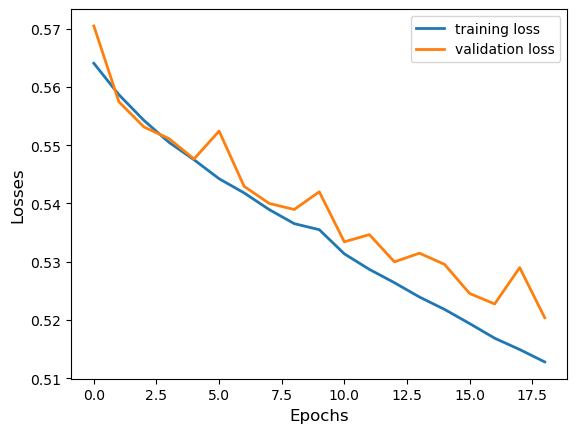

In [35]:
plt.plot(range(len(train_losses[1:])), train_losses[1:], 
         linewidth = 2.0, 
         label = 'training loss')

plt.plot(range(len(val_losses[1:])), val_losses[1:], 
         linewidth = 2.0, 
         label = 'validation loss')

plt.xlabel("Epochs", size = 12)
plt.ylabel("Losses", size = 12)
plt.legend()

plt.savefig('figures/losses.pdf') 
plt.show()

## 6. Testing

- Nous écrivons une fonction de prédiction qui calcule la précision et le rapport de classification du train set et du test set.

In [86]:
def predict(model, test_dataloader):
    labels_l = []
    preds_l = []
    
    # Modèle en mode eval
    model.eval()
    
    # Testing loop
    with torch.no_grad():
        
        for i, batch in enumerate(test_dataloader):
            
            data, labels = reshape_batch(batch)
            data, labels = data.to(device), labels.to(device)
            
            labels_l.extend(labels.tolist())
            
            preds = model.to(device)
            preds = model(data)
            
            preds = torch.argmax(preds, dim = 1)
            preds_l.extend(preds.tolist())
    
    return labels_l, preds_l

In [87]:
train_labels, train_preds = predict(network, train_dataloader)
test_labels, test_preds = predict(network, test_dataloader)

In [88]:
print(classification_report(train_labels, train_preds, digits = 4))

              precision    recall  f1-score   support

         0.0     0.6930    0.8015    0.7433    307746
         1.0     0.7327    0.6051    0.6628    276673

    accuracy                         0.7085    584419
   macro avg     0.7128    0.7033    0.7031    584419
weighted avg     0.7118    0.7085    0.7052    584419



In [89]:
print(classification_report(test_labels, test_preds, digits = 4))

              precision    recall  f1-score   support

         0.0     0.6469    0.7511    0.6951    191173
         1.0     0.6622    0.5434    0.5970    171664

    accuracy                         0.6529    362837
   macro avg     0.6546    0.6473    0.6460    362837
weighted avg     0.6542    0.6529    0.6487    362837



## 7. Save

- Sauvegarde du modèle entraîné.

In [41]:
cwd = os.getcwd()
path = os.path.join(cwd, "model.pt")
path_2 = os.path.join(cwd, "best_model.pt")

In [42]:
# Save last model
torch.save(network.state_dict(), path) 

In [43]:
# Load best model
network_2 = Network()

network_2.load_state_dict(torch.load(path))
network_2.eval()

Network(
  (fc1): Linear(in_features=27, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=2, bias=True)
)

In [44]:
test_labels, test_preds = predict(network_2, test_dataloader)

In [45]:
print(classification_report(test_labels, test_preds))

              precision    recall  f1-score   support

         0.0       0.65      0.75      0.70    191173
         1.0       0.66      0.54      0.60    171664

    accuracy                           0.65    362837
   macro avg       0.65      0.65      0.65    362837
weighted avg       0.65      0.65      0.65    362837



- Explications :<br>
L'IA est entraînée sur la durée totale des parties étudiées. Au tout début d'une partie, connaître le vainqueur est quasiment impossible, ce qui entraîne de possibles résultats aléatoires. Les résultats deviennent meilleurs lorsqu'il est demandé de prédire le vainqueur d'une partie lorsque l'état de celle-ci est suffisamment avancé.<br>
Nous étudierons par la suite des cas pratiques illustrés.

## 8. Cas pratiques

- Nous allons par la suite analyser deux replays étape par étape en les illustrant.<br>
Commençons par obtenir et afficher nos prédictions pour ces deux replays.

In [96]:
test_datasetPrime = Data_test("archive/testSetPrime.csv")
test_dataloaderPrime = DataLoader(test_datasetPrime, batch_size = 128, shuffle = True)

def predictPrime(model, test_dataloaderPrime):
    labels_l = []
    preds_l = []
    
    # Modèle en mode eval
    model.eval()
    
    # Testing loop
    with torch.no_grad():
        
        for i, batch in enumerate(test_dataloaderPrime):
            
            data, labels = reshape_batch(batch)
            data, labels = data.to(device), labels.to(device)
            
            labels_l.extend(labels.tolist())
            
            preds = model.to(device)
            preds = model(data)
            
            preds = torch.argmax(preds, dim = 1)
            preds_l.extend(preds.tolist())
    
    return labels_l, preds_l

test_labelsPrime, test_predsPrime = predict(network_2, test_dataloaderPrime)

print(test_labelsPrime)
print("/////////////////")
print(test_predsPrime)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
/////////////////
[1, 1, 1, 1, 0, 0, 1, 0]


- Nous avons ci-dessus en premier tableau indiquant le joueur ayant gagné, ici le joueur 1 lors des deux parties étudiées.<br>
En dessous se trouvent les prédictions de l'IA.